<a href="https://colab.research.google.com/github/Tahimi/convectionDiffusion/blob/main/advectionDiffusion2D_FipyFiniteVolume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install fipy
# uncomment to install fipy, restart (runtime env.) and execute all

In [2]:
import numpy as np
from fipy import *

In [3]:
# space discretization
w = h = 1000 # m
dx = dy = 10 # m
nx, ny = int(w/dx), int(h/dy)
mesh = Grid2D(nx=nx, dx=dx, ny=ny, dy=dy)
print('cellsNbr = ', mesh.globalNumberOfCells)

cellsNbr =  10000


In [4]:
# time discretization
# advection
vx = vy = 2. # m/s
Cr = 0.8 # Courant Number: Cr = u*dt/dx
dtAdv = abs(Cr*dx/max(vx,vy))
# diffusion
Fr = 0.5 # Fourier Number: Fr = D*dt/dx**2
D = 20.
dtDiff = abs(Fr*dx**2/D)
# advectionDiffusion
dt = min(dtAdv,dtDiff)
delT = 5*60. # sec
stepsNbr = int(delT/dt)

In [5]:
# defining the unkown's distribution
def distributionIn2D(x, y, zMin, zMax, xc, yc, width, isRectangular = True):
  if isRectangular:
    # rectangular distribuition
    return np.array([zMax if xc-width < xi
                     and xi < xc+width
                     and yc-width < yi
                     and yi < yc+width
                     else zMin
                     for xi in x
                     for yi in y])
  else:
    # Gaussian distribuition
    return zMin + zMax * np.exp(-((x-xc)**2+(y-yc)**2) / (2*width**2))

In [6]:
# initialization
zMin, zMax = 200, 1200
xc, yc = 250, 250
width = 40

def initialize():
    # unkown's initialization
    global mesh, zMin, zMax, xc, yc, width, zInit, z
    zInitValue = distributionIn2D(x=mesh.x,
                                  y=mesh.y,
                                  zMin=zMin,
                                  zMax=zMax,
                                  xc=xc,
                                  yc=yc,
                                  width=width,
                                  isRectangular=False)
    zInit = CellVariable(mesh=mesh, value=zInitValue)
    z = CellVariable(mesh=mesh, value=zInit)

    # Applying noFlow BC
    z.faceGrad.constrain((0,), where=mesh.exteriorFaces)

    # Defining the discritized equation
    global D, eq
    eq = (TransientTerm(coeff=1.0) + PowerLawConvectionTerm(coeff=(vx,vy))
       == DiffusionTerm(coeff=D))

In [7]:
# defining the time-step update function
def advectAndDiffuse1(y, dt):
    eq.solve(var=y, dt=dt)

In [8]:
# display some parameters
print('dx = ', dx, '\n'
      'dy = ', dy, '\n'
      'vx = ', vx, '\n'
      'vy = ', vy, '\n'
      'Cr = ', Cr, '\n'
      'dtAdv = ', dt, '\n'
      'D = ', D, '\n'
      'Fr = ', Fr, '\n'
      'dtDiff = ', dt, '\n'
      'dt = min(dtAdv,dtDiff) = ', dt, '\n'
      'stepsNbr = ', stepsNbr)

dx =  10 
dy =  10 
vx =  2.0 
vy =  2.0 
Cr =  0.8 
dtAdv =  2.5 
D =  20.0 
Fr =  0.5 
dtDiff =  2.5 
dt = min(dtAdv,dtDiff) =  2.5 
stepsNbr =  120


In [9]:
# initialize and iterate in time
initialize()
for step in range(stepsNbr):
    advectAndDiffuse1(z, dt)

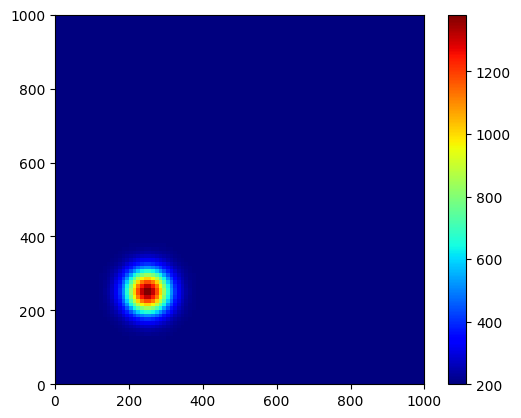

In [10]:
# ploting the unkown's initial distribution
viewer = Viewer(vars = (zInit),
                datamin = zInit.min()-.1,
                datamax = zInit.max()+.1)
viewer.plot()

After 300.0  (sec)


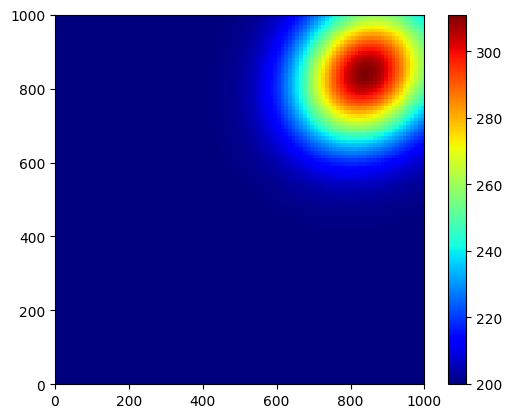

In [11]:
# ploting the unkown's final distribution
print('After', dt*stepsNbr, ' (sec)')
viewer = Viewer(vars = (z),
                datamin = z.min()-.1,
                datamax = z.max()+.1)
viewer.plot()